# Time-integrated point source search analysis example

## Software setup

In [1]:
import sys

# Add skyllh and i3skyllh projects to the PYTHONPATH
sys.path.insert(0, '/opt/nu-workshop-software/skyllh')
sys.path.insert(0, '/opt/nu-workshop-software/i3skyllh')

# Add missing python packages from cvmfs
sys.path.insert(-1, '/cvmfs/icecube.opensciencegrid.org/py3-v4.1.1/RHEL_7_x86_64/lib/python3.7/site-packages')

## Create `datasets` object

The ``i3skyllh.analyses.kdepdf_mcbg_ps.analysis`` support datasets where PDFs are pre-generated using the KDE method:

    NorthernTracks_v005p00_KDE_PDF_v007: IC86_2011 -- IC86_2019
    NorthernTracks_v005p01_KDE_PDF_v007: IC86_2011 -- IC86_2021 (with additionally added NuTau simulation datasets to MC)

The following analyses should support all datasets as they generate PDFs either from experimental or MC data:

    i3skyllh.analyses.trad_diffuse_ps.analysis: uses MC data for PDF generation
    i3skyllh.analyses.trad_stacking.analysis: same as above, with additional support for stacking multiple sources
    i3skyllh.analyses.IC170922A_wGFU.analysis: uses scrambled experimental data for PDF generation

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from skyllh.core.config import CFG
from skyllh.core.random import RandomStateService
from skyllh.core.timing import TimeLord
from skyllh.physics.source import PointLikeSource

# Pre-defined datasets
from i3skyllh.datasets import data_samples

#Pre-defined analysis
from i3skyllh.analyses.kdepdf_mcbg_ps import analysis as kde_analysis

In [3]:
# Update global settings to use 2 cpu cores
CFG['multiproc']['ncpu'] = 2

In [4]:
# `data_samples` contains common datasets
print('\n'.join(data_samples.keys()))

DiffuseNorthernTracks
DiffuseNorthernTracks_v001p00
FastResponse
FastResponse_v001p00
GammaRays5yr_GalPlane
GammaRays5yr_PointSrc
GFU
GFU_v002p01
GFU_v002p02
GFU_v002p03
GFU_v002p04
GFU_v002p05
NorthernTracks
NorthernTracks_v001p00
NorthernTracks_v001p01
NorthernTracks_v002p00
NorthernTracks_v002p01
NorthernTracks_v002p02
NorthernTracks_v002p05
NorthernTracks_v002p05_KDE_PDF_v001
NorthernTracks_v002p06
NorthernTracks_v003p00_KDE_PDF_v002
NorthernTracks_v003p00_KDE_PDF_v003
NorthernTracks_v003p01_KDE_PDF_v004
NorthernTracks_v003p01_KDE_PDF_v005
NorthernTracks_v003p01_KDE_PDF_v006
NorthernTracks_v003p01_KDE_PDF_v007
NorthernTracks_v003p01_KDE_PDF_v008
NorthernTracks_v003p01_KDE_PDF_v010
NorthernTracks_v003p01_KDE_PDF_v200
NorthernTracks_v003p02
NorthernTracks_v003p02_KDE_PDF_v514
NorthernTracks_v003p02_KDE_PDF_v200
NorthernTracks_v003p03_KDE_PDF_v001
NorthernTracks_v004p02_KDE_PDF_v003
NorthernTracks_v004p03_KDE_PDF_v003
NorthernTracks_v004p03_KDE_PDF_v003_abs_plus5
NorthernTracks_v004p0

In [5]:
# Specify base path for datasets
data_base_path = '/data/ana/analyses'

# Load specific dataset collection
dsc = data_samples['NorthernTracks_v005p00_KDE_PDF_v007'].create_dataset_collection(
            base_path=data_base_path)

# Pick a dataset or create a list of datasets from the dataset collection
datasets = dsc.get_datasets('IC86_2011-IC86_2019')

In [6]:
# Define some common analysis parameters
refplflux_gamma = 2.0
minimizer_impl = None
optimize_delta_angle = 15.0
rss_seed = 0

## Create the `analysis` object

In [7]:
# Define initial source object
source = PointLikeSource(ra=np.deg2rad(0.), dec=np.deg2rad(0.))

In [8]:
ana_kde = kde_analysis.create_analysis(
    datasets,
    source,
    bkg_event_rate_field_names=['astro', 'conv'],
    refplflux_gamma=refplflux_gamma,
    fit_gamma=True,
    livetime_list=None,
    compress_data=True,
    minimizer_impl = None,
    ns_seed=10,
    evt_sel_meth='spatialbox',
    optimize_delta_angle=optimize_delta_angle
)

[==========================================================] 100% ELT 0h:00m:05s
[==========================================================] 100% ELT 0h:00m:27s


In [9]:
# Generate background trials
rss = RandomStateService(rss_seed)
res_kde_bg = ana_kde.do_trials(rss, n=10, mean_n_sig=0)

[==========================================================] 100% ELT 0h:00m:02s


In [10]:
print(res_kde_bg)
print(res_kde_bg.dtype)

[(         0, 0., 0, 0., 0.        ,  0.        , 4.32      )
 (         0, 0., 0, 0., 1.21271706, 21.23037032, 4.32      )
 (         0, 0., 0, 0., 9.01908854, 45.88625054, 3.26054356)
 (         0, 0., 0, 0., 3.18068896, 34.29298547, 4.304168  )
 (         0, 0., 0, 0., 1.84836277, 15.58076763, 2.85521549)
 (2357136044, 0., 0, 0., 0.42464366, 12.35818168, 4.32      )
 (2357136044, 0., 0, 0., 0.        ,  0.        , 4.32      )
 (2357136044, 0., 0, 0., 0.75896145,  4.11593086, 2.46722167)
 (2357136044, 0., 0, 0., 0.        ,  0.        , 4.32      )
 (2357136044, 0., 0, 0., 0.10965291,  5.86736425, 3.76596544)]
[('seed', '<i8'), ('mean_n_sig', '<f8'), ('n_sig', '<i8'), ('mean_n_sig_0', '<f8'), ('ts', '<f8'), ('ns', '<f8'), ('gamma', '<f8')]


In [11]:
# Generate signal trials
rss = RandomStateService(rss_seed)
res_kde_sig = ana_kde.do_trials(rss, n=10, mean_n_sig=10)

[==========================================================] 100% ELT 0h:00m:03s


In [12]:
res_kde_sig

array([(         0, 10., 17, 0., 33.89473687,  6.83243832, 1.72601027),
       (         0, 10., 11, 0., 38.27240369, 23.33243568, 2.29233034),
       (         0, 10.,  8, 0., 17.28659423, 10.0379805 , 2.08599903),
       (         0, 10., 12, 0., 53.18912891, 14.19218552, 1.94005555),
       (         0, 10.,  8, 0.,  5.63640429, 12.33887108, 2.45187456),
       (2357136044, 10.,  6, 0., 15.59138863,  6.05664926, 1.90644407),
       (2357136044, 10., 10, 0., 32.04935684, 11.63282164, 1.97287869),
       (2357136044, 10., 13, 0., 52.04710171, 14.58093905, 1.90490158),
       (2357136044, 10., 10, 0., 34.96024899, 14.80401748, 2.12596618),
       (2357136044, 10., 11, 0., 30.6592404 , 26.47856509, 2.4626625 )],
      dtype=[('seed', '<i8'), ('mean_n_sig', '<f8'), ('n_sig', '<i8'), ('mean_n_sig_0', '<f8'), ('ts', '<f8'), ('ns', '<f8'), ('gamma', '<f8')])

In [13]:
# Change source
new_source = PointLikeSource(ra=np.deg2rad(180.), dec=np.deg2rad(10.))
ana_kde.change_source(new_source)

In [14]:
# Use TimeLord object to time code execution
tl = TimeLord()
with tl.task_timer('Running signal trials.'):
    rss = RandomStateService(rss_seed)
    res_kde_sig_new = ana_kde.do_trials(rss, n=10, mean_n_sig=10, tl=tl)
print(tl)

[==========================================================] 100% ELT 0h:00m:03s
TimeLord: Executed tasks:
[Calculate total MC background mean.             ]   0.012 sec/iter (2)
[Calculate MC background event probability cache.]   0.044 sec/iter (2)
[ESM-DecBand: Calculate mask_dec                 ]   0.035 sec/iter (2)
[ESM-DecBand: Calculate mask.                    ]   0.002 sec/iter (2)
[ESM-DecBand: Create selected_events.            ]   0.303 sec/iter (2)
[Pre-select MC events.                           ]   0.342 sec/iter (2)
[Calculate selected MC background mean.          ]   0.004 sec/iter (10)
[Get p array.                                    ]   0.005 sec/iter (10)
[Draw MC background indices.                     ]   0.188 sec/iter (10)
[Select MC background events from indices.       ]   0.057 sec/iter (10)
[Scramble MC background data.                    ]   0.005 sec/iter (10)
[Remove MC specific data fields from MC events.  ] 4.4e-05 sec/iter (10)
[Generating background 

## Some utility functions

In [15]:
from skyllh.core.analysis_utils import (
    estimate_sensitivity,
    estimate_discovery_potential,
    create_trial_data_file
)

In [16]:
help(estimate_sensitivity)

Help on function estimate_sensitivity in module skyllh.core.analysis_utils:

estimate_sensitivity(ana, rss, h0_trials=None, h0_ts_quantile=0.5, p=0.9, eps_p=0.005, mu_range=None, min_dmu=0.5, bkg_kwargs=None, sig_kwargs=None, ppbar=None, tl=None, pathfilename=None)
    Estimates the mean number of signal events that whould have to be
    injected into the data such that the test-statistic value of p*100% of all
    trials are larger than the critical test-statistic value c, which
    corresponds to the test-statistic value where h0_ts_quantile*100% of all
    null hypothesis test-statistic values are larger than c.
    
    For sensitivity h0_ts_quantile, and p are usually set to 0.5, and 0.9,
    respectively.
    
    Parameters
    ----------
    ana : Analysis
        The Analysis instance to use for sensitivity estimation.
    rss : RandomStateService
        The RandomStateService instance to use for generating random
        numbers.
    h0_trials : (n_h0_ts_vals,)-shaped ndarra

In [17]:
n_trials = 10
pathfilename = './trials.npy'
_ = create_trial_data_file(ana_kde, rss, n_trials, mean_n_sig=(0, 2), mean_n_sig_null=0, pathfilename=pathfilename)

[==========================================================] 100% ELT 0h:00m:10s


In [18]:
trials = np.load(pathfilename)
print(trials)
print(trials.dtype)

[(         0, 0., 0, 0., 2.37792439, 29.47689755, 3.47483629)
 (         0, 0., 0, 0., 3.66065822, 37.62555335, 3.62767194)
 (         0, 0., 0, 0., 0.        ,  0.        , 4.32      )
 (         0, 0., 0, 0., 0.        ,  0.        , 4.32      )
 (         0, 0., 0, 0., 0.25702203,  6.94773778, 3.09499838)
 (  67063811, 0., 0, 0., 0.05713375,  3.8414052 , 3.39262385)
 (  67063811, 0., 0, 0., 0.        ,  0.        , 4.32      )
 (  67063811, 0., 0, 0., 0.        ,  0.        , 1.35002828)
 (  67063811, 0., 0, 0., 0.16680563,  8.41961013, 4.16223629)
 (  67063811, 0., 0, 0., 2.22488861, 30.99016472, 3.82911278)
 (         0, 1., 3, 0., 8.0467189 ,  1.39964911, 1.37576735)
 (         0, 1., 2, 0., 0.        ,  0.        , 4.32      )
 (         0, 1., 1, 0., 4.46716848,  1.76233826, 1.73617887)
 (         0, 1., 0, 0., 0.        ,  0.        , 3.03507199)
 (         0, 1., 2, 0., 2.95189502, 17.32074596, 3.06333542)
 (1800623582, 1., 0, 0., 9.83445431, 72.03145667, 4.32      )
 (180062

## Pseudo data example

In [19]:
# Generate background events.
(bg_n_events_list, bg_events_list) = ana_kde.generate_background_events(
    rss=rss,
)

# Generate signal events.
(n_sig, sig_n_events_list, sig_events_list) = ana_kde.generate_signal_events(
    rss=rss,
    mean_n_sig=10
)

In [20]:
print(sig_events_list[0])

DataFieldRecordArray: 17 fields, 6 entries, 2 Kbytes 
    fields = {
        zen          : {dtype: float32, vmin:  1.717e+00, vmax:  1.757e+00}
        dec          : {dtype: float32, vmin:  1.526e-01, vmax:  1.878e-01}
        ra           : {dtype: float32, vmin:  3.108e+00, vmax:  3.161e+00}
        run          : {dtype: int64, vmin:  2.112e+04, vmax:  2.122e+04}
        time         : {dtype: float32, vmin:  5.678e+04, vmax:  5.678e+04}
        azi          : {dtype: float32, vmin:  1.316e+00, vmax:  5.498e+00}
        log_energy   : {dtype: float32, vmin:  3.313e+00, vmax:  6.240e+00}
        ang_err      : {dtype: float32, vmin:  3.472e-03, vmax:  2.033e-02}
        true_energy  : {dtype: float32, vmin:  9.641e+03, vmax:  4.491e+06}
        true_ra      : {dtype: float32, vmin:  2.198e-01, vmax:  5.741e+00}
        true_dec     : {dtype: float32, vmin:  1.544e-01, vmax:  1.876e-01}
        mcweight     : {dtype: float64, vmin:  5.034e+03, vmax:  1.522e+10}
        astro        

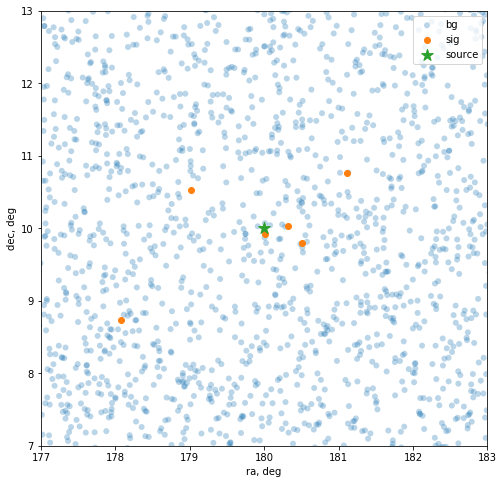

In [21]:
delta_angle = 3.0

plt.figure(figsize=(8, 8))

# Scatter background and signal events.
plt.scatter(np.rad2deg(bg_events_list[0]['ra']), np.rad2deg(bg_events_list[0]['dec']), label='bg', alpha=0.3, edgecolors='none')
plt.scatter(np.rad2deg(sig_events_list[0]['ra']), np.rad2deg(sig_events_list[0]['dec']), label='sig')
plt.scatter(np.rad2deg(new_source.ra), np.rad2deg(new_source.dec), marker='*', label='source', s=150)

plt.xlabel('ra, deg')
plt.ylabel('dec, deg')
plt.xlim(np.rad2deg(new_source.ra) - delta_angle, np.rad2deg(new_source.ra) + delta_angle)
plt.ylim(np.rad2deg(new_source.dec) - delta_angle, np.rad2deg(new_source.dec) + delta_angle)
plt.legend()